## 03 - CNN for time series classification.ipynb

In this notebook:  
Scale the values (important in CNN)  
Split the DataFrame into timesteps  
The train/test split  
Develop the model  
Metrics evaluation  

In [22]:
# import libraries
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [23]:
# load data
df = pd.read_csv("cleaned_df.csv")
df

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_time_numeric
0,1,1082,2027,5758.59,0,2,30,0,43,2027,1672531200
1,2,1015,2053,1901.56,1,3,47,2,61,2053,1672531201
2,3,1004,2035,1248.86,1,2,6,0,57,2035,1672531202
3,4,1095,2037,7619.05,1,1,6,5,59,2037,1672531203
4,5,1036,2083,1890.10,1,2,34,4,36,2083,1672531204
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,8935.28,1,2,39,3,36,2023,1672541195
9996,9997,1053,2026,30.15,0,2,32,4,42,2026,1672541196
9997,9998,1041,2034,6333.64,0,0,1,2,36,2034,1672541197
9998,9999,1009,2019,2837.13,1,3,11,4,57,2019,1672541198


In [24]:
 # this dataformat is not suitable yet for CNN time series classification
# because each point is separate in the dataset

# we have to process the data into smaller chunks -> for example
# chunks of 50 points at a time

In [25]:
# check that columns are dropped
df.head()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_time_numeric
0,1,1082,2027,5758.59,0,2,30,0,43,2027,1672531200
1,2,1015,2053,1901.56,1,3,47,2,61,2053,1672531201
2,3,1004,2035,1248.86,1,2,6,0,57,2035,1672531202
3,4,1095,2037,7619.05,1,1,6,5,59,2037,1672531203
4,5,1036,2083,1890.10,1,2,34,4,36,2083,1672531204


In [26]:
# Scale the values (important in CNN)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cale only relevant variables
num_cols = ['customer_id', 'merchant_id', 'amount']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [27]:
# check scaling
df.head()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_time_numeric
0,1,0.818182,0.262626,0.575423,0,2,30,0,43,2027,1672531200
1,2,0.141414,0.525253,0.189301,1,3,47,2,61,2053,1672531201
2,3,0.030303,0.343434,0.123960,1,2,6,0,57,2035,1672531202
3,4,0.949495,0.363636,0.761671,1,1,6,5,59,2037,1672531203
4,5,0.353535,0.828283,0.188153,1,2,34,4,36,2083,1672531204


In [28]:
# instead of the date-column and old index,
# let's use a sequence number
# starting from 1 until the final row

# Add a sequence column starting from 1
df['sequence'] = df.index + 1

# drop the column
columns_to_drop = ['transaction_time_numeric']
df = df.drop(columns=columns_to_drop, axis=1)

# Reorder columns
columns = ['sequence'] + [col for col in df.columns if col != 'sequence']
df = df[columns]

In [29]:
df.tail()

,sequence,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
9995,9996,9996,0.555556,0.222222,0.893437,1,2,39,3,36,2023
9996,9997,9997,0.525253,0.252525,0.001956,0,2,32,4,42,2026
9997,9998,9998,0.404040,0.333333,0.632990,0,0,1,2,36,2034
9998,9999,9999,0.080808,0.181818,0.282959,1,3,11,4,57,2019
9999,10000,10000,0.818182,0.696970,0.720665,1,1,1,0,50,2070


In [31]:
#  Split the DataFrame into timesteps
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

# separate the output variables
meantemp = df['is_fraudulent'].values
wind_speed = df['customer_age'].values

# generate timestep windows for each signal
meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)
wind_speed_windows = sliding_window_view(wind_speed, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((meantemp_windows, wind_speed_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(meantemp_windows) + [1] * len(wind_speed_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (19902, 50)
y: (19902,)


In [32]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

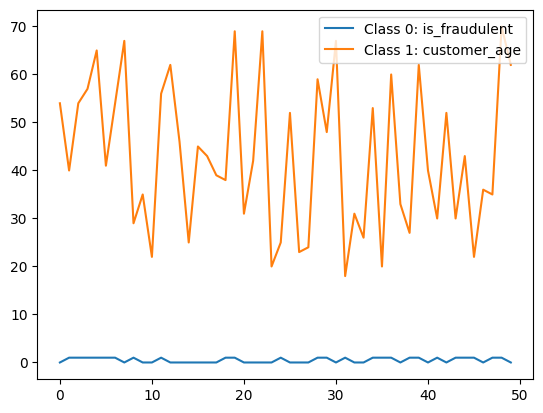

In [ ]:
# let's create the plot for comparing two classes 
# across a selected signal (sequence of data) 
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: is_fraudulent")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: customer_age")
plt.legend()

# The orange line shows significant variability, 
# meaning customer age varies widely across 
# transactions in Class 1 (fraudulent transactions).
# This might suggest that fraudulent activity occurs across a wide age range.

In [34]:
#  the train/test split

# define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

13931
5971
13931
5971


In [35]:
x_train

array([[24, 26, 32, ..., 40, 26, 70],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 1,  0,  1, ...,  0,  1,  0],
       ...,
       [51, 51, 39, ..., 18, 24, 25],
       [ 1,  1,  0, ...,  1,  0,  0],
       [66, 63, 60, ..., 50, 47, 36]], dtype=int64)

In [ ]:
# convert the data into the required CNN -format
# usually the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [37]:
x_train

array([[[24],
        [26],
        [32],
        ...,
        [40],
        [26],
        [70]],

       [[ 0],
        [ 0],
        [ 0],
        ...,
        [ 1],
        [ 1],
        [ 1]],

       [[ 1],
        [ 0],
        [ 1],
        ...,
        [ 0],
        [ 1],
        [ 0]],

       ...,

       [[51],
        [51],
        [39],
        ...,
        [18],
        [24],
        [25]],

       [[ 1],
        [ 1],
        [ 0],
        ...,
        [ 1],
        [ 0],
        [ 0]],

       [[66],
        [63],
        [60],
        ...,
        [50],
        [47],
        [36]]], dtype=int64)

In [39]:
class_names = np.array(["is_fraudulent", "customer_age"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

In [42]:
from tensorflow import keras

epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# add the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,          
    restore_best_weights=True  
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9533 - val_loss: 2.0504e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7219e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.0122e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7055e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 9.9974e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6988e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.5154e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9800e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6889e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2967e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.8395e

<Axes: >

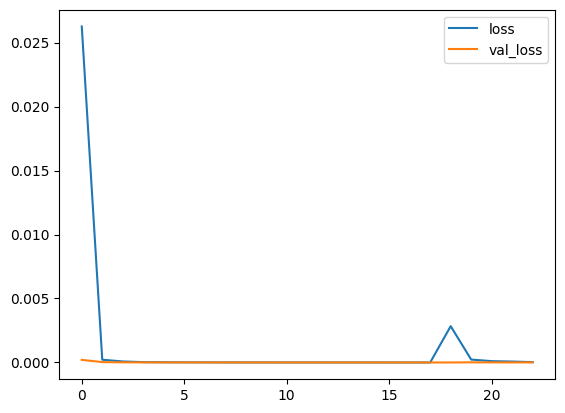

In [ ]:
# loss plot
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

# Both loss and val_loss sharply decrease in the first few epochs
# This is expected as the model quickly learns 
# to reduce the error during the early stages of training

# The spike in the training loss at one point may indicate 
# some instability in training (e.g., noisy gradients). 
# This can sometimes happen if the learning rate 
# is too high or the data is noisy.

In [ ]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

# voi voi :)
# something went wrong
# I think this is because 2 targets
# I am not sure that I was supposed to choose 2 targets

Test data evaluation:
[5.989413132123644e-11, 1.0]

Train data evaluation:
[1.3691396627546482e-10, 1.0]


In [46]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)
 

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

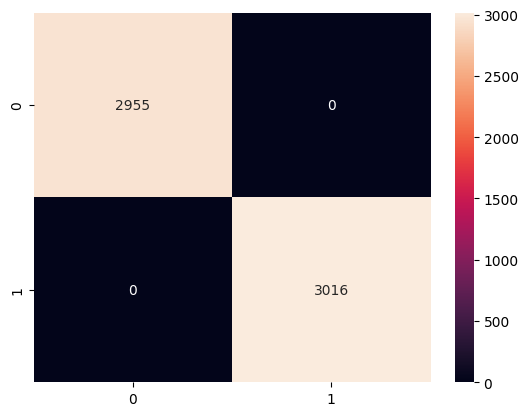

In [ ]:
 # confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# Top-left (True Negatives): 2955
# Top-right (False Positives): 0
# Bottom-left (False Negatives): 0
# Bottom-right (True Positives): 3016

# to be honest, even though, I am an optimist
# but this one looks too good to be realistic

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# ahaha, 100%
# sorry, but I do not believe these metrics
# probably, because of 2 target variables

# but I checked my teacher's notebook
# he also has 100%
# okay, maybe because the data is synthetic
# it shows very good results

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2955
           1       1.00      1.00      1.00      3016

    accuracy                           1.00      5971
   macro avg       1.00      1.00      1.00      5971
weighted avg       1.00      1.00      1.00      5971


Model overall accuracy: 100.00%


1
customer_age


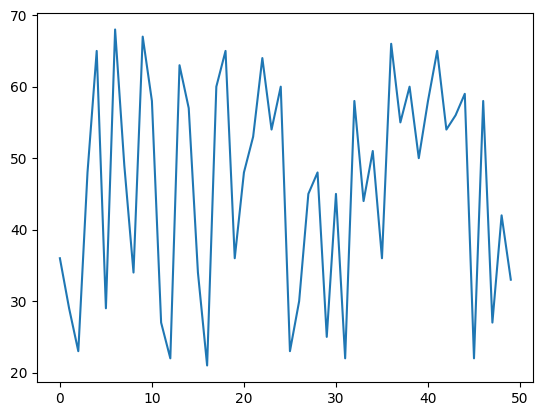

In [50]:
#  Test the model with some imaginary/synthetic signal examples from ChatGPT
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

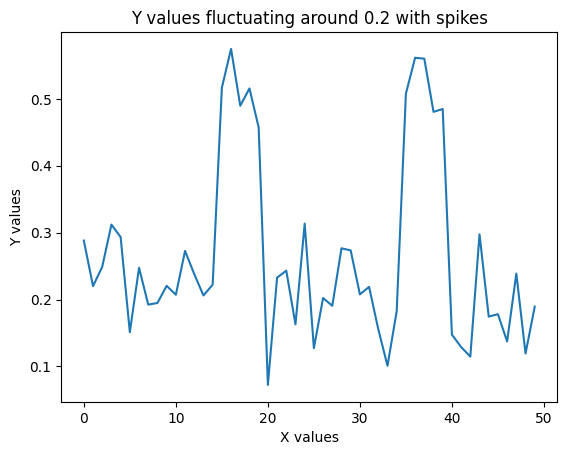

In [51]:
 import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [53]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[1.000000e+00 3.604539e-08]]
is_fraudulent


0
is_fraudulent


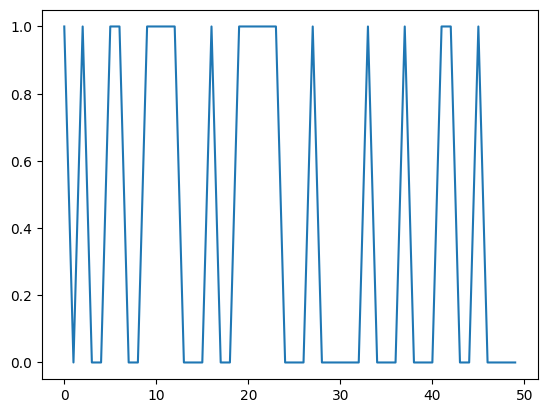

In [54]:
signal_index = 22
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

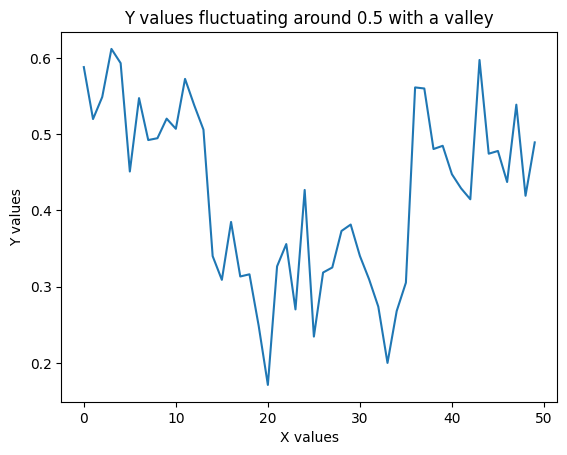

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [56]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.0000000e+00 4.0038504e-08]]
is_fraudulent


In [66]:
import pickle

# save the model to a file
with open("CNN_model.pkl", "wb") as file: 
    pickle.dump(model, file)
print("Model saved successfully!")


Model saved successfully!
